# Sound speed as a source of modified gravity

In Horndeski theory, the dark energy sound speed is given by the basis functions $\alpha_M$, $\alpha_B$, $\alpha_K$ and $\alpha_T$:

\begin{equation}
    c_s^2 = \frac{1}{\alpha_K + \frac{3}{2}\alpha_B^2}\left[ (2 - \alpha_B)\left(-\frac{H'}{aH^2} + \frac{\alpha_B}{2}(1 + \alpha_T) + \alpha_M - \alpha_T\right) - \frac{3(\rho_\mathrm{tot} + P_\mathrm{tot})}{H^2M_*^2} + \frac{\alpha_B'}{aH}\right].
\end{equation}

The term $\alpha_T$ is assumed to be zero. We can further assume $M_* = 1$, implying $\alpha_M = 0$. We obtain:

\begin{equation}
    c_s^2 = \frac{1}{\alpha_K + \frac{3}{2}\alpha_B^2}\left[ (2 - \alpha_B)\left(-\frac{H'}{aH^2} + \frac{\alpha_B}{2}\right) - \frac{3(\rho_\mathrm{tot} + P_\mathrm{tot})}{H^2} + \frac{\alpha_B'}{aH}\right].
\end{equation}

This equation can be inverted, isolating $\alpha_B'$:

\begin{equation}
    \left(\alpha_K + \frac{3}{2}\alpha_B^2 \right)c_s^2 = (2 - \alpha_B)\left(-\frac{H'}{aH^2} + \frac{\alpha_B}{2}\right) - \frac{3(\rho_\mathrm{tot} + P_\mathrm{tot})}{H^2} + \frac{\alpha_B'}{aH},
\end{equation}

\begin{equation}
    \frac{\alpha_B'}{aH} = \frac{d\alpha_B}{d\ln a} = \left(\alpha_K + \frac{3}{2}\alpha_B^2 \right)c_s^2 + (\alpha_B - 2)\left(-\frac{H'}{aH^2} + \frac{\alpha_B}{2} \right) + \frac{3(\rho_\mathrm{tot} + P_\mathrm{tot})}{H^2}.
\end{equation}

Inserting some background properties,

\begin{equation}
    H^2 = \frac{\rho}{3}; \;\; \dot{H} + H^2 = -\frac{1}{6}(\rho + 3P),
\end{equation}

we find

\begin{equation}
    \frac{\alpha_B'}{aH} = \frac{d\alpha_B}{d\ln a} = \left(\alpha_K + \frac{3}{2}\alpha_B^2 \right)c_s^2 + (\alpha_B - 2)\left(\frac{3}{2}(1 + w_t) + \frac{\alpha_B}{2} \right) + 9(1 + w_t).
\end{equation}

In terms of the $\mu-\Sigma$ parametrization, we find

\begin{equation}
    \mu = \Sigma = 1 + \frac{\alpha_B^2}{2c_s^2\left(\alpha_K + \frac{3}{2}\alpha_B^2\right)}
\end{equation}

Let's explore the solutions for $\alpha_B$ and $\mu$ assuming $\alpha_K = \lambda \alpha_B$.

In [1]:
import numpy as np
import camb
from scipy.interpolate import interp1d
from scipy.integrate import odeint, solve_ivp
import matplotlib as mpl
import matplotlib.pyplot as plt

## Engine

In [2]:
def rho_de(a, w0, wa, omega_de):
    return omega_de*a**(-3*(1 + w0 + wa))*np.exp(-3*wa*(1-a))

def rho_m(a, omega_m):
    return omega_m*a**-3

def rho_gamma(a, omega_r):
    return omega_r*a**-4

def w_tot(a, omega_m, omega_de, omega_r, w0, wa):
    w_de = w0 + wa*(1-a)
    rhog = rho_gamma(a, omega_r)
    rhom = rho_m(a, omega_m)
    rhode = rho_de(a, w0, wa, omega_de)
    rhotot = rhog + rhode + rhom
    return (rhog/3 + w_de*rhode)/rhotot, ((4/3)*rhog + rhom)/rhotot # NOTE: last term is (rho_no_de + P_no_de)/rho_tot

def deriv(loga, alpha_B, lmbda=1, cs2=1, omega_m=0.3, w0=-1, wa=0):
    omega_r = 2.5e-5
    omega_de = 1 - omega_m - omega_r
    a = np.exp(loga)
    wt, last_term = w_tot(a, omega_m, omega_de, omega_r, w0, wa)
    alpha_K = lmbda * alpha_B
    return cs2*(alpha_K + 1.5*alpha_B**2) + (alpha_B - 2)*(1.5*(1 + wt) + 0.5*alpha_B) + 3*last_term

def solve_alpha_B(lmbda, cs2, omega_m, w0, wa, alpha_B_init=0, method="euler"):
    a_ini = 1e-5
    a_final = 1
    if method == "scipy":
        return solve_ivp(deriv, (np.log(a_ini), np.log(a_final)), y0=(alpha_B_init,),  args=(lmbda, cs2, omega_m, w0, wa))
    elif method == "euler":
        alpha_B = alpha_B_init
        N = 200 # Number of steps
        dloga = (np.log(a_final) - np.log(a_ini))/N
        result = [alpha_B]
        loga = np.linspace(np.log(a_ini), np.log(a_final), N+1)
        for i in range(N):
            alpha_B += deriv(loga[i], alpha_B, lmbda, cs2, omega_m, w0, wa)*dloga
            result.append(alpha_B)
        alpha_B = np.array(result)
        mu = 1 + alpha_B**2/2/(lmbda*alpha_B + 1.5*alpha_B**2)/cs2
        return loga*np.log10(np.e), alpha_B, mu
    else:
        raise Exception("Unknown method")
    
def study_alpha_B(lmbda, cs2, omega_m, w0, wa):
    # Returns the derivative of alpha_B, evaluated in a grid of alpha_B, log(a)
    # Useful when assessing the stability of the system
    N_loga = 100 # Number of steps
    a_ini = 1e-5
    loga = np.linspace(np.log(a_ini), 0, N_loga)
    N_alpha_B = 100
    alpha_B = np.linspace(-10, 10, N_alpha_B)
    result = np.zeros((N_loga, N_alpha_B))
    for i in range(N_loga):
        for j in range(N_alpha_B):
            result[i, j] = deriv(loga[i], alpha_B[j], lmbda, cs2, omega_m, w0, wa)
    return result, loga*np.log10(np.e), alpha_B

## One Cosmology

/tmp/ipykernel_16790/54821042.py:41: RuntimeWarning: invalid value encountered in divide
  mu = 1 + alpha_B**2/2/(lmbda*alpha_B + 1.5*alpha_B**2)/cs2


Text(0, 0.5, '$\\mu$')

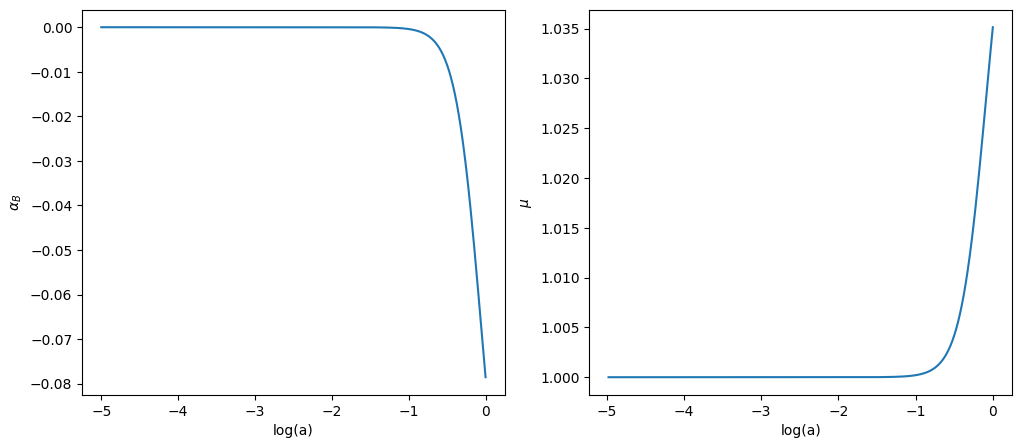

In [27]:
reference_cosmo = {
    "omega_m": 0.3,
    "w0": -0.9,
    "wa": 0,
    "cs2": 1,
    "lmbda": -1,
    "alpha_B_init": 0
}

log_a, alpha_B, mu = solve_alpha_B(**reference_cosmo, method="euler")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(log_a, alpha_B)
axs[0].set_xlabel("log(a)")
axs[0].set_ylabel("$\\alpha_B$")
axs[1].plot(log_a, mu)
axs[1].set_xlabel("log(a)")
axs[1].set_ylabel("$\\mu$")
# plt.savefig("plots/alpha_B_solution.pdf")

## Sampling across parameter space

### 1. Star Sampling

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_16790/3011126969.py:25: SyntaxWarning: invalid escape sequence '\m'
  "alpha_B_init": "$\\alpha_{B,\mathrm{init}}$",
/tmp/ipykernel_16790/54821042.py:41: RuntimeWarning: invalid value encountered in divide
  mu = 1 + alpha_B**2/2/(lmbda*alpha_B + 1.5*alpha_B**2)/cs2
/tmp/ipykernel_16790/54821042.py:41: RuntimeWarning: invalid value encountered in divide
  mu = 1 + alpha_B**2/2/(lmbda*alpha_B + 1.5*alpha_B**2)/cs2
/tmp/ipykernel_16790/54821042.py:41: RuntimeWarning: invalid value encountered in divide
  mu = 1 + alpha_B**2/2/(lmbda*alpha_B + 1.5*alpha_B**2)/cs2
/tmp/ipykernel_16790/54821042.py:41: RuntimeWarning: invalid value encountered in divide
  mu = 1 + alpha_B**2/2/(lmbda*alpha_B + 1.5*alpha_B**2)/cs2
/tmp/ipykernel_16790/54821042.py:41: RuntimeWarning: divide by zero encountered in divide
  mu = 1 + alpha_B**2/2/(lmbda*alpha_B + 1.5*alpha_B**2)/cs2
/tmp/ipykernel_

Error for params {'omega_m': 0.3, 'w0': -0.95, 'wa': 0, 'cs2': 1, 'lmbda': 0.5, 'alpha_B_init': np.float64(0.11111111111111116)}
Error for params {'omega_m': 0.3, 'w0': -0.95, 'wa': 0, 'cs2': 1, 'lmbda': 0.5, 'alpha_B_init': np.float64(0.33333333333333326)}
Error for params {'omega_m': 0.3, 'w0': -0.95, 'wa': 0, 'cs2': 1, 'lmbda': 0.5, 'alpha_B_init': np.float64(0.5555555555555554)}
Error for params {'omega_m': 0.3, 'w0': -0.95, 'wa': 0, 'cs2': 1, 'lmbda': 0.5, 'alpha_B_init': np.float64(0.7777777777777777)}
Error for params {'omega_m': 0.3, 'w0': -0.95, 'wa': 0, 'cs2': 1, 'lmbda': 0.5, 'alpha_B_init': np.float64(1.0)}


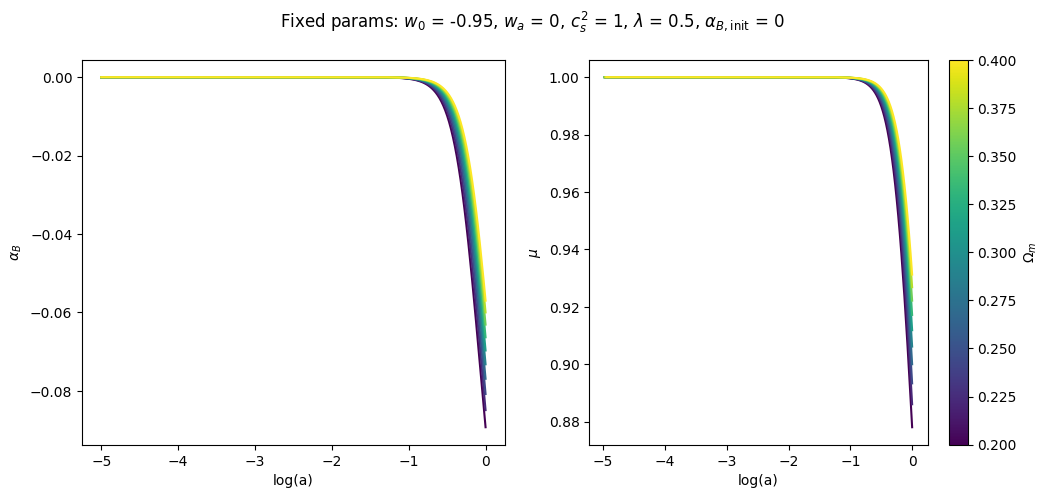

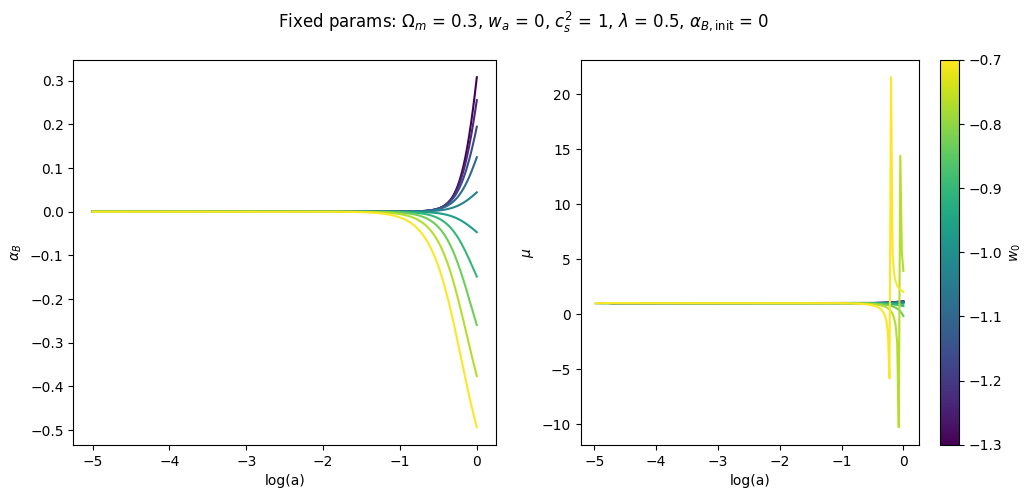

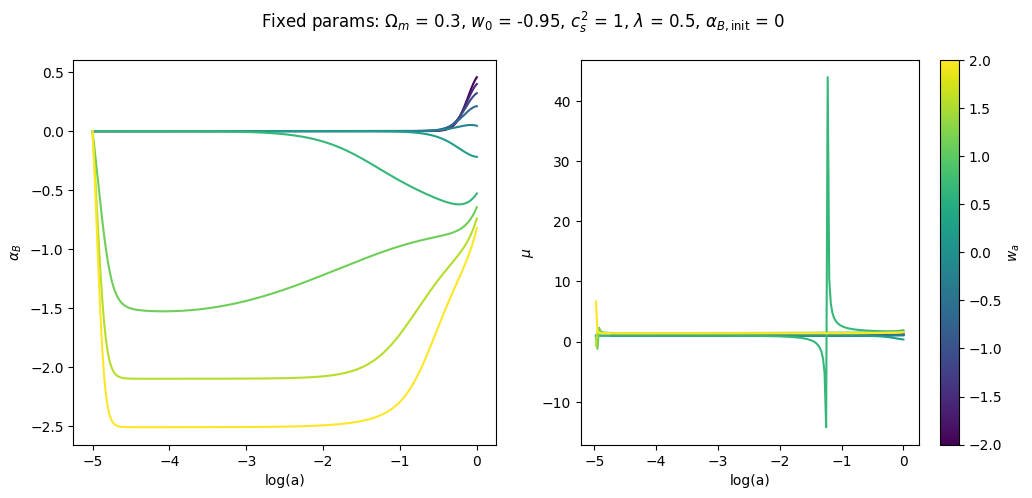

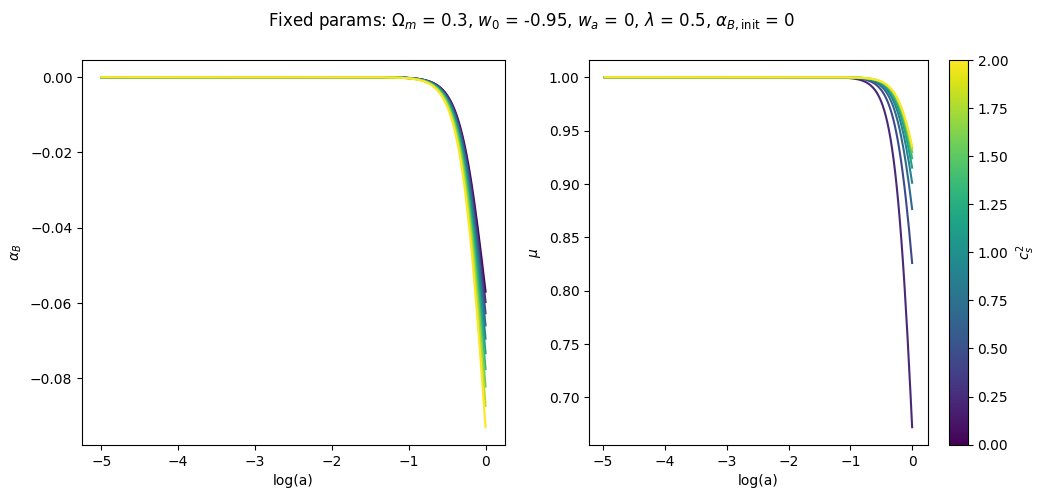

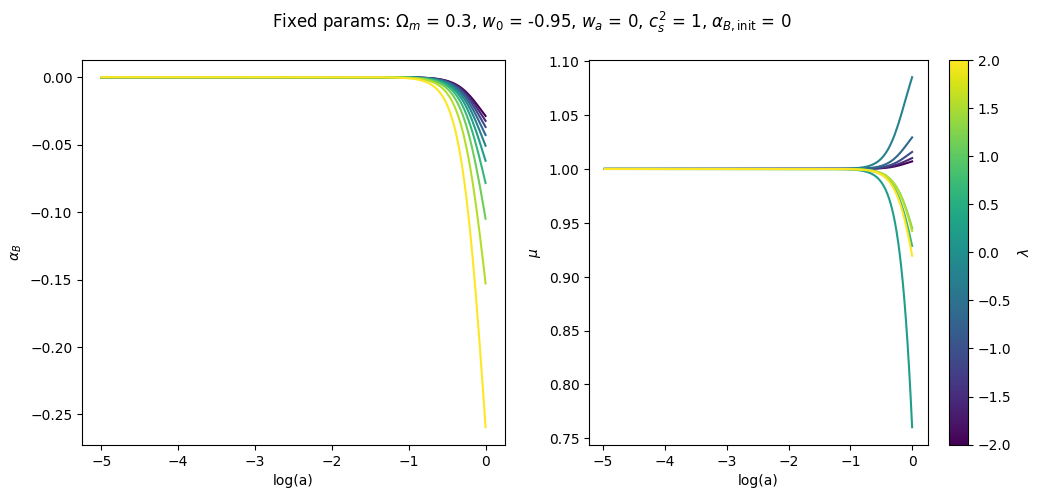

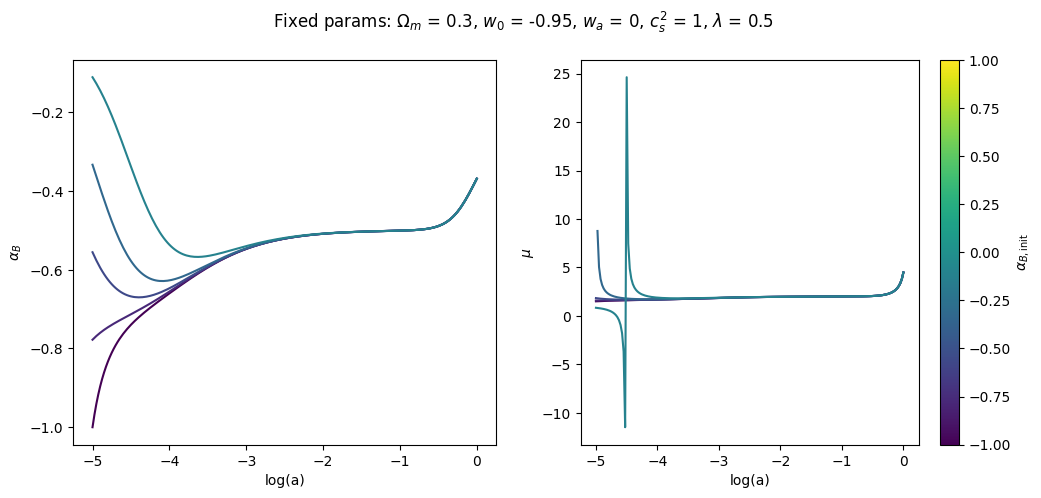

In [34]:
reference_cosmo = {
    "omega_m": 0.3,
    "w0": -0.95,
    "wa": 0,
    "cs2": 1,
    "lmbda": 0.5,
    "alpha_B_init": 0
}

grids = {
    "omega_m": np.linspace(0.2, 0.4, 10),
    "w0"     : np.linspace(-1.3, -0.7, 10),
    "wa"     : np.linspace(-2, 2, 10),
    "cs2"    : np.linspace(0, 2, 10),
    "lmbda"  : np.linspace(-2, 2, 10),
    "alpha_B_init": np.linspace(-1, 1, 10), # NOTE: solution converges to attractor quickly
}

param_name_latex = {
    "omega_m": "$\\Omega_m$",
    "w0"     : "$w_0$",
    "wa"     : "$w_a$",
    "cs2"    : "$c_s^2$",
    "lmbda": "$\\lambda$",
    "alpha_B_init": "$\\alpha_{B,\mathrm{init}}$",
}

cmap = plt.get_cmap('viridis')

for param_name in grids.keys():
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    params = reference_cosmo.copy()
    norm = mpl.colors.Normalize(vmin=grids[param_name][0], vmax=grids[param_name][-1])
    for param_value in grids[param_name]:
        params[param_name] = param_value
        loga, alpha_B, mu = solve_alpha_B(**params, method="euler")
        if np.any(alpha_B > 10) or np.any(alpha_B < -10):
            print(f"Error for params {params}")
            continue
        color = cmap(norm(param_value))
        axs[0].plot(loga, alpha_B, color=color)
        axs[1].plot(loga, mu, color=color)
    for ax in axs:
        ax.set_xlabel("log(a)")
    axs[0].set_ylabel("$\\alpha_B$")
    axs[1].set_ylabel("$\\mu$")
    
    del params[param_name]
    title = ", ".join([" = ".join((param_name_latex[name], f"{value}")) for (name, value) in params.items()])
    fig.suptitle(f"Fixed params: {title}")

    # Create a ScalarMappable for the colorbar (no data required)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # for colorbar compatibility

    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(param_name_latex[param_name])
    plt.savefig(f"plots/alpha_B_solutions_propalphaK/{param_name}_scan.pdf")


### 2. Random Sampling

/tmp/ipykernel_16790/54821042.py:41: RuntimeWarning: invalid value encountered in divide
  mu = 1 + alpha_B**2/2/(lmbda*alpha_B + 1.5*alpha_B**2)/cs2
/tmp/ipykernel_16790/1000161135.py:18: RuntimeWarning: invalid value encountered in divide
  mu = 1 + alpha_B**2/2/(params_dict['lmbda']*alpha_B + 1.5*alpha_B**2)/params_dict['cs2']
/tmp/ipykernel_16790/54821042.py:41: RuntimeWarning: overflow encountered in square
  mu = 1 + alpha_B**2/2/(lmbda*alpha_B + 1.5*alpha_B**2)/cs2
/tmp/ipykernel_16790/1000161135.py:18: RuntimeWarning: overflow encountered in square
  mu = 1 + alpha_B**2/2/(params_dict['lmbda']*alpha_B + 1.5*alpha_B**2)/params_dict['cs2']


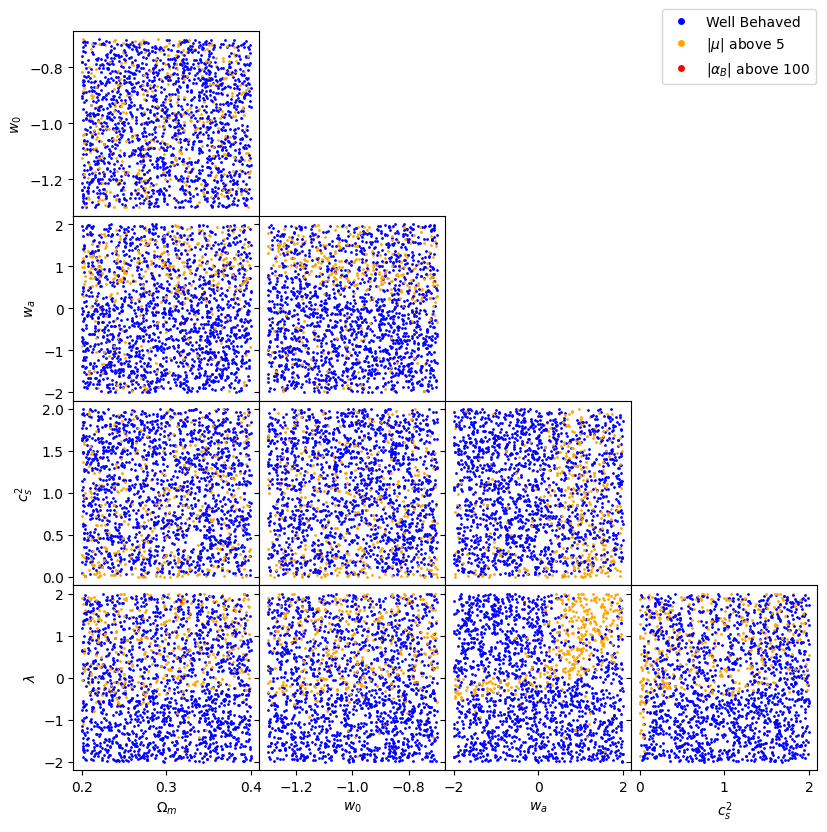

In [38]:
priors = {
    "omega_m": [0.2, 0.4],
    "w0"     : [-1.3, -0.7],
    "wa"     : [-2, 2],
    "cs2"    : [0, 2],
    "lmbda"  : [-2, 2],
}
priors_array = np.array(list(priors.values()))

alpha_B_threshold = 100
mu_threshold = 5

samples = []
for i in range(2_000):
    params = np.random.rand(len(priors))*(priors_array[:,1]-priors_array[:,0]) + priors_array[:,0]
    params_dict = dict(zip(priors.keys(), params))
    log_a, alpha_B, mu = solve_alpha_B(**params_dict, method="euler")
    mu = 1 + alpha_B**2/2/(params_dict['lmbda']*alpha_B + 1.5*alpha_B**2)/params_dict['cs2']
    if np.any(alpha_B > alpha_B_threshold) or np.any(alpha_B < -alpha_B_threshold):
        samples.append((params, "red"))
    elif np.any(mu > mu_threshold) or np.any(mu < -mu_threshold):
        samples.append((params, "orange"))
    else:
        samples.append((params, "blue"))


fig, axs = plt.subplots(len(params), len(params), figsize=(12, 12), gridspec_kw={"hspace": 0, "wspace": 0})
for row in range(len(params)):
    for col in range(len(params)):
        ax = axs[row, col]
        if row == len(params)-1: ax.set_xlabel(list(param_name_latex.values())[col])
        else: ax.set_xticklabels([])
        if col == 0:             ax.set_ylabel(list(param_name_latex.values())[row])
        else: ax.set_yticklabels([])
            
        if col >= row: ax.remove()
        for sample in samples:
            point, color = sample
            ax.scatter(point[col], point[row], color=color, s=1)

blue_circle = mpl.lines.Line2D([], [], marker="o", color="w", markerfacecolor="blue", label="Well Behaved", )
orange_circle = mpl.lines.Line2D([], [], marker="o", color="w", markerfacecolor="orange", label=f"$|\\mu|$ above {mu_threshold}", )
red_circle = mpl.lines.Line2D([], [], marker="o", color="w", markerfacecolor="red", label=f"$|\\alpha_B|$ above {alpha_B_threshold}", )
fig.legend(handles=[blue_circle, orange_circle, red_circle], bbox_to_anchor=(0.75, 0.75))

plt.savefig("plots/alpha_B_solutions_propalphaK/alpha_B_samples.pdf", bbox_inches="tight")

## Using CAMB

In [59]:
# Example cosmology
def get_camb_solution(alpha_K, cs2, omega_m, w0, wa):
    ombh2 = 0.0122
    h = 0.7
    omch2 = (omega_m - ombh2/h**2)*h**2
    cosmo = camb.set_params(
        H0=100*h, ombh2=ombh2, omch2=omch2, As=2.1e-9, ns=0.96, tau=0.06,
        num_nu_massless=3.044, WantTransfer=True, w=w0, wa=wa,
        dark_energy_model="fluid" if (1+w0)*(1+w0+wa) > 0 else "ppf",
        cs2_0=cs2, use_cs2=True, alpha_K=alpha_K
    )
    results = camb.get_background(cosmo)
    log_a = results.Params.log_a
    alpha_B = results.Params.alpha_B
    mu = results.Params.mu
    return log_a, alpha_B, mu

In [62]:
alpha_K = -5
cs2 = 1.0
omega_m = 0.3
w0 = -0.9
wa = -0.5
log_a_camb, alpha_B_camb, mu_camb = get_camb_solution(alpha_K, cs2, omega_m, w0, wa)
log_a_py,   alpha_B_py,   mu_py   = solve_alpha_B(alpha_K, cs2, omega_m, w0, wa)

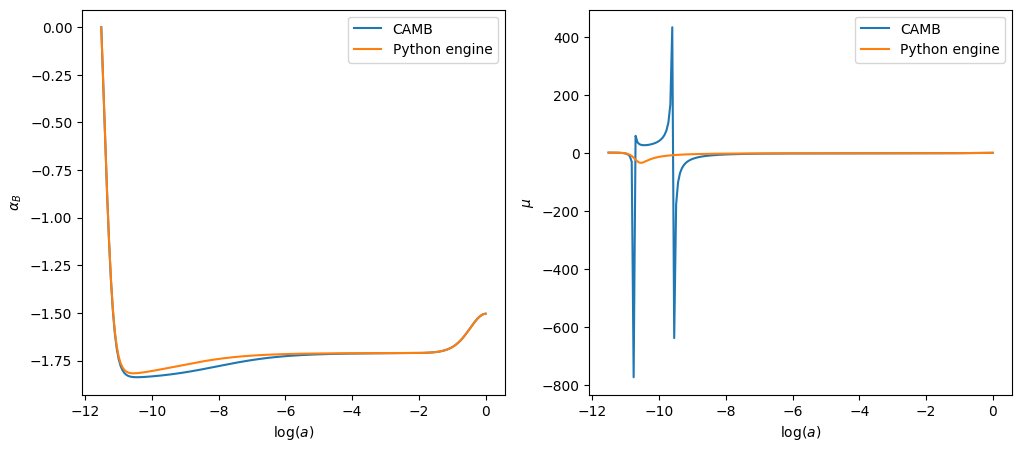

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(log_a_camb, alpha_B_camb, label="CAMB")
axs[0].plot(log_a_py, alpha_B_py, label="Python engine")
axs[0].set_xlabel("$\\log(a)$")
axs[0].set_ylabel("$\\alpha_B$")
axs[0].legend()

axs[1].plot(log_a_camb, mu_camb, label="CAMB")
axs[1].plot(log_a_py,   mu_py, label="Python engine")
axs[1].set_xlabel("$\\log(a)$")
axs[1].set_ylabel("$\\mu$")
axs[1].legend()

In [49]:
alpha_B_camb[180]

0.47401937871529537

In [50]:
alpha_B_py[180]

np.float64(0.1599047898462004)